<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/llava_multi_modal_tesla_10q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Retrieval-Augmented Image Captioning

In this example, we show how to leverage [LLaVa + Replicate](https://replicate.com/yorickvp/llava-13b) for image understanding/captioning and retrieve relevant unstructured text and embedded tables from Tesla 10K file according to the image understanding.

1. LlaVa can provide image understanding based on user prompt.
2. We use Unstructured to parse out the tables, and use LlamaIndex recursive retrieval to index/retrieve tables and texts.
3. We can leverage the image understanding from Step 1 to retrieve relevant information from knowledge base generated by Step 2 (which is indexed by LlamaIndex)

Context for LLaVA: Large Language and Vision Assistant
* [Website](https://llava-vl.github.io/)
* [Paper](https://arxiv.org/abs/2304.08485)
* [Github](https://github.com/haotian-liu/LLaVA)
* LLaVA is now supported in llama.cpp with 4-bit / 5-bit quantization support: [See here.](https://github.com/ggerganov/llama.cpp/pull/3436) [Deprecated]
* LLaVA 13b is now supported in Replicate: [See here.](https://replicate.com/yorickvp/llava-13b)

For LlamaIndex:
LlaVa+Replicate enables us to run image understanding locally and combine the multi-modal knowledge with our RAG knowledge base system.

TODO:
Waiting for [llama-cpp-python](https://github.com/abetlen/llama-cpp-python) supporting LlaVa model in python wrapper.
So LlamaIndex can leverage `LlamaCPP` class for serving LlaVa model directly/locally.

## Using Replicate serving LLaVa model through LlamaIndex


### Build and Run LLaVa models locally through Llama.cpp (Deprecated)

1. git clone [https://github.com/ggerganov/llama.cpp.git](https://github.com/ggerganov/llama.cpp.git)
2. `cd llama.cpp`. Checkout llama.cpp repo for more details.
3. `make`
4. Download Llava models including `ggml-model-*` and `mmproj-model-*` from [this Hugging Face repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main). Please select one model based on your own local configuration
5. `./llava` for checking whether llava is running locally

In [ ]:
%load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [ ]:
! pip install unstructured

In [ ]:
from unstructured.partition.html import partition_html
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

## Perform Data Extraction from Tesla 10K file


In these sections we use Unstructured to parse out the table and non-table elements.

### Extract Elements

We use Unstructured to extract table and non-table elements from the 10-K filing.

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://docs.google.com/uc?export=download&id=1THe1qqM61lretr9N3BmINc_NWDvuthYf" -O shanghai.jpg
!wget "https://docs.google.com/uc?export=download&id=1PDVCf_CzLWXNnNoRV8CFgoJxv6U0sHAO" -O tesla_supercharger.jpg

In [ ]:
from llama_index.readers.file.flat_reader import FlatReader
from pathlib import Path

reader = FlatReader()
docs_2021 = reader.load_data(Path("tesla_2021_10k.htm"))

In [ ]:
from llama_index.node_parser import (
    UnstructuredElementNodeParser,
)

node_parser = UnstructuredElementNodeParser()

In [ ]:
import os

REPLICATE_API_TOKEN = ""  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

In [ ]:
import openai

OPENAI_API_TOKEN = "sk-"
openai.api_key = OPENAI_API_TOKEN  # add your openai api key here
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [ ]:
import os
import pickle

if not os.path.exists("2021_nodes.pkl"):
    raw_nodes_2021 = node_parser.get_nodes_from_documents(docs_2021)
    pickle.dump(raw_nodes_2021, open("2021_nodes.pkl", "wb"))
else:
    raw_nodes_2021 = pickle.load(open("2021_nodes.pkl", "rb"))

In [ ]:
base_nodes_2021, node_mappings_2021 = node_parser.get_base_nodes_and_mappings(
    raw_nodes_2021
)

## Setup Recursive Retriever

Now that we've extracted tables and their summaries, we can setup a recursive retriever in LlamaIndex to query these tables.

### Construct Retrievers

In [ ]:
from llama_index.retrievers import RecursiveRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index import VectorStoreIndex

In [ ]:
# construct top-level vector index + query engine
vector_index = VectorStoreIndex(base_nodes_2021)
vector_retriever = vector_index.as_retriever(similarity_top_k=2)
vector_query_engine = vector_index.as_query_engine(similarity_top_k=2)

In [ ]:
from llama_index.retrievers import RecursiveRetriever

recursive_retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=node_mappings_2021,
    verbose=True,
)
query_engine = RetrieverQueryEngine.from_args(recursive_retriever)

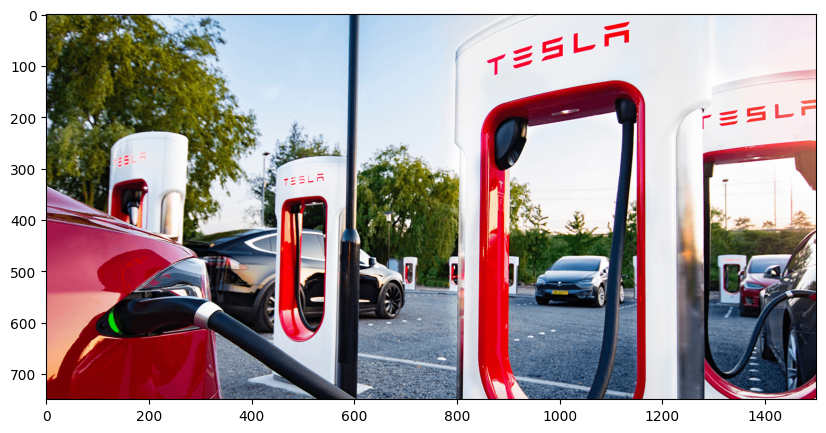

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./tesla_supercharger.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Running LLaVa model using Replicate through LlamaIndex for image understanding

In [ ]:
from llama_index.multi_modal_llms import ReplicateMultiModal
from llama_index.schema import ImageDocument
from llama_index.multi_modal_llms.replicate_multi_modal import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
    max_new_tokens=200,
    temperature=0.1,
)

prompt = "what is the main object for tesla in the image?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

### Retrieve relevant information from LlamaIndex knowledge base according to LLaVa image understanding

In [ ]:
prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

Retrieving with query id None: please provide relevant information about: Tesla super charger station
Retrieved node with id, entering: id_431_table
Retrieving with query id id_431_table: please provide relevant information about: Tesla super charger station
Retrieving text node: Additionally, our team has expertise in selecting and working with a range of materials for our vehicles to balance performance, cost and durability in ways that are best suited for our vehicles’ target demographics and utility. We have also used our capabilities to achieve complex engineering feats in stamping, casting and thermal systems, and are currently developing designs that integrate batteries directly with vehicle body structures without separate battery packs to optimize manufacturability, weight, range and cost characteristics.

We are also expanding our manufacturing operations globally while taking action to localize our vehicle designs and production for particular markets, including country-spec

### Showing final RAG image caption results from LlamaIndex

In [ ]:
print(str(rag_response))

Tesla Supercharger stations are part of Tesla's growing global network of high-speed vehicle chargers. These Supercharger stations are typically located along well-traveled routes and in dense city centers to provide Tesla vehicle owners with quick, reliable, and convenient charging options. The Supercharger network is designed to allow for minimal stops during long-distance travel. Tesla aims to co-locate Superchargers with their solar and energy storage systems whenever possible to promote renewable power and reduce costs. The use of the Supercharger network may require payment of a fee or be free under certain sales programs. Additionally, Tesla works with various hospitality, retail, and public destinations, as well as businesses with commuting employees, to offer additional charging options through their Destination Charging program. This program utilizes Tesla Wall Connectors to provide charging to Tesla vehicle owners who patronize or work at these establishments. Tesla also col

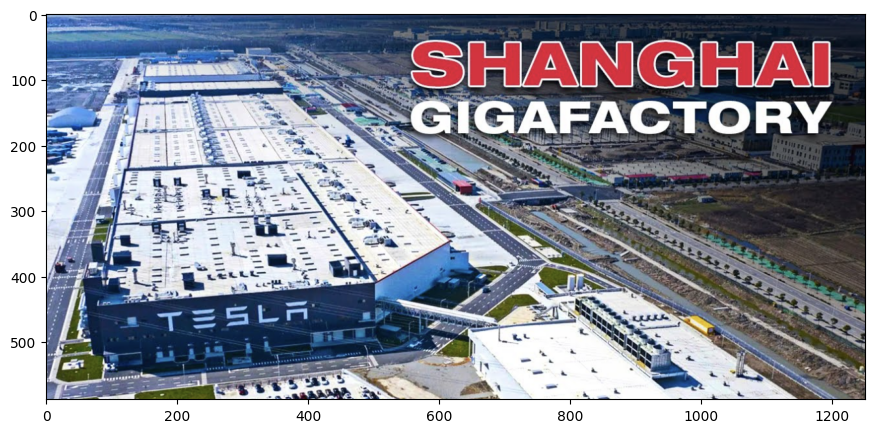

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

imageUrl = "./shanghai.jpg"
image = Image.open(imageUrl).convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image)

### Retrieve relevant information from LlamaIndex for a new image

In [ ]:
prompt = "which Tesla factory is shown in the image?"

llava_response = multi_modal_llm.complete(
    prompt=prompt,
    image_documents=[ImageDocument(image_path=imageUrl)],
)

In [ ]:
prompt_template = "please provide relevant information about: "
rag_response = query_engine.query(prompt_template + llava_response.text)

Retrieving with query id None: please provide relevant information about: a large Tesla factory with a white roof, located in Shanghai, China. The factory is surrounded by a parking lot filled with numerous cars, including both small and large vehicles. The cars are parked in various positions, some closer to the factory and others further away. The scene gives an impression of a busy and well-organized facility, likely producing electric vehicles for the global market
Retrieved node with id, entering: id_431_table
Retrieving with query id id_431_table: please provide relevant information about: a large Tesla factory with a white roof, located in Shanghai, China. The factory is surrounded by a parking lot filled with numerous cars, including both small and large vehicles. The cars are parked in various positions, some closer to the factory and others further away. The scene gives an impression of a busy and well-organized facility, likely producing electric vehicles for the global mark

### Showing final RAG image caption results from LlamaIndex

In [ ]:
print(rag_response)

The Gigafactory Shanghai in Shanghai, China is a large Tesla factory that produces electric vehicles for the global market. The factory has a white roof and is surrounded by a parking lot filled with numerous cars, including both small and large vehicles. The cars are parked in various positions, some closer to the factory and others further away. This scene gives an impression of a busy and well-organized facility.
